# House price prediction
### 08/14/2021

Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

# The Goal
- We have 79 variables that describe the characteristics of a house.
- Our goal is to predict the SalePrice, given these features.
- Our models are evaluated on the Root-Mean-Squared-Error (RMSE) between the log of the SalePrice predicted by our model, and the log of the actual SalePrice. 

# Exploratory Data Analysis

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# stats
from scipy import stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax


# missing value
from sklearn.impute import SimpleImputer

import warnings
warnings.filterwarnings('ignore')


In [51]:
# Load data
df_train = pd.read_csv('../data/raw/train.csv')
df_test = pd.read_csv('../data/raw/test.csv')
print(df_train.shape,df_test.shape)

(1460, 81) (1459, 80)


train data has 81 variables with 1460 data points, and test data has 80 variables (no houseprice variable) with 1459 data points.

In [52]:
# column information
print(df_train.columns)
df_train.columns.shape

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

(81,)

We have 81 columns in the data. Entire column description can be found in ../data/raw/data_dexcrption.txt

The target variable here is 'SalePrice' which is numeric variable.

In [53]:
df_train['Id'].head()

0    1
1    2
2    3
3    4
4    5
Name: Id, dtype: int64

ID column doesn't add any information so it should be dropped from further analysis.

In [54]:
df_train = df_train.drop(['Id'], axis=1)
df_test = df_test.drop(['Id'], axis=1)

Let's explore data type of each variable.

In [55]:
# Categorical data
print(df_train.dtypes[df_train.dtypes=='object'].shape)
df_train.dtypes[df_train.dtypes=='object']

(43,)


MSZoning         object
Street           object
Alley            object
LotShape         object
LandContour      object
Utilities        object
LotConfig        object
LandSlope        object
Neighborhood     object
Condition1       object
Condition2       object
BldgType         object
HouseStyle       object
RoofStyle        object
RoofMatl         object
Exterior1st      object
Exterior2nd      object
MasVnrType       object
ExterQual        object
ExterCond        object
Foundation       object
BsmtQual         object
BsmtCond         object
BsmtExposure     object
BsmtFinType1     object
BsmtFinType2     object
Heating          object
HeatingQC        object
CentralAir       object
Electrical       object
KitchenQual      object
Functional       object
FireplaceQu      object
GarageType       object
GarageFinish     object
GarageQual       object
GarageCond       object
PavedDrive       object
PoolQC           object
Fence            object
MiscFeature      object
SaleType        

We have 43 category features out of 80 entire features. (without ID column)

In [56]:
# Numerical data
print(df_train.dtypes[df_train.dtypes!='object'].shape)
df_train.dtypes[df_train.dtypes!='object']

(37,)


MSSubClass         int64
LotFrontage      float64
LotArea            int64
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
MasVnrArea       float64
BsmtFinSF1         int64
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
1stFlrSF           int64
2ndFlrSF           int64
LowQualFinSF       int64
GrLivArea          int64
BsmtFullBath       int64
BsmtHalfBath       int64
FullBath           int64
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
TotRmsAbvGrd       int64
Fireplaces         int64
GarageYrBlt      float64
GarageCars         int64
GarageArea         int64
WoodDeckSF         int64
OpenPorchSF        int64
EnclosedPorch      int64
3SsnPorch          int64
ScreenPorch        int64
PoolArea           int64
MiscVal            int64
MoSold             int64
YrSold             int64
SalePrice          int64
dtype: object

We have 37 numerical features.

There are some non-numerical features are in numbers.
- MSSubClass: Identifies the type of dwelling involved in the sale.
- YrSold: Year Sold (YYYY)
- MoSold: Month Sold (MM)
- GarageYrBlt: Year garage was built <br>
We will convert those features into objects.

In [57]:
# 3 non-numeric predictors are stored as numbers; convert them into objects 
# MSSubClass: Identifies the type of dwelling involved in the sale.
df_train['MSSubClass'] = df_train['MSSubClass'].astype('object')
df_test['MSSubClass'] = df_test['MSSubClass'].astype('object')

# YrSold: Year Sold (YYYY)
df_train['YrSold'] = df_train['YrSold'].astype('object')
df_test['YrSold'] = df_test['YrSold'].astype('object')

# MoSold: Month Sold (MM)
df_train['MoSold'] = df_train['MoSold'].astype('object')
df_test['MoSold'] = df_test['MoSold'].astype('object')

# GarageYrBlt: Year garage was built
df_train['GarageYrBlt'] = df_train['GarageYrBlt'].astype('object')
df_test['GarageYrBlt'] = df_test['GarageYrBlt'].astype('object')

## SalePrice

SalePrice is a dependent variable we should predict. Let's see this first. 

In [58]:
df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

The average is 180921 with 79442 for standard deviation. The median (163000) is smaller than std, so we can expect that SalePrice might be right skewed. Then, let's check this with histogram. 

<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

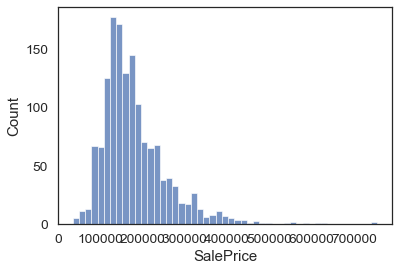

In [59]:
sns.histplot(data=df_train, x='SalePrice')

As expected, the SalePrice is right skewed. We need to convert this to normal distribution since regression models usually don't work well with dependent variable that is non-normally distributed. We'll do that later. 

### Relationship among important features with SalePrice :

Let's look around features expected to have important relationship with SalePrice. <br>

When roughly thinking about the things that determine houseprices, the following 4 features seem important. <br>

1) 'GrLivArea' (Above grade (ground) living area square feet) <br>
2) 'TotalBsmtSF' (Total square feet of basement area) <br>
3) 'OverallQual' (Rates the overall material and finish of the house) <br>
4) 'YearBuilt'.

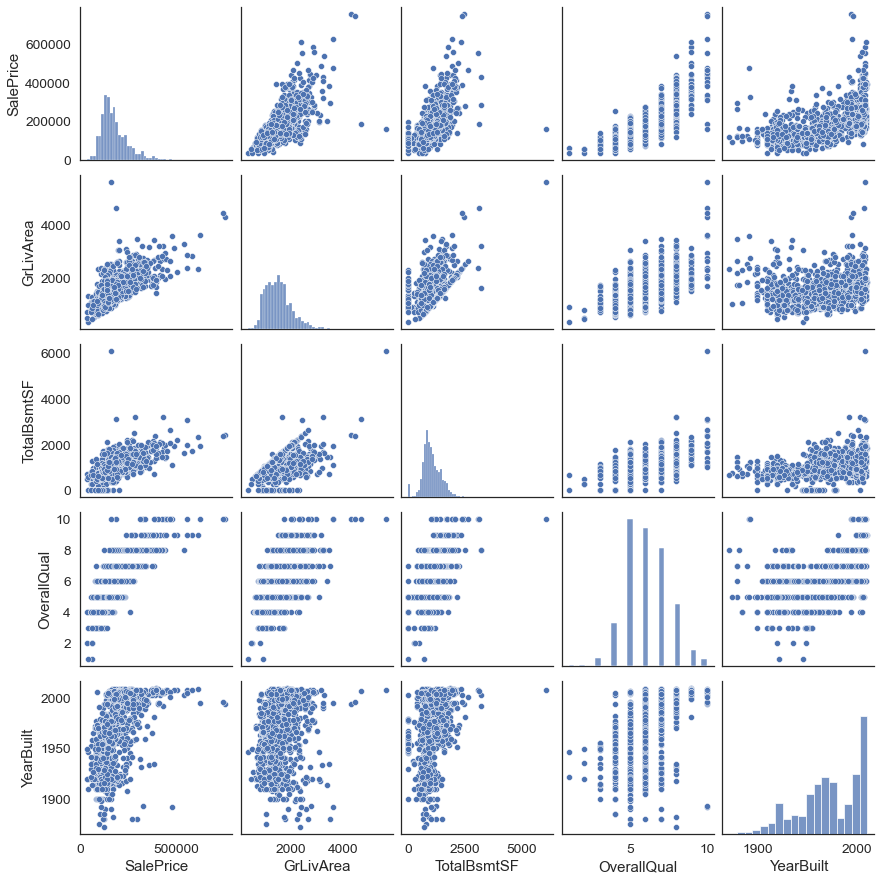

In [60]:
sns.pairplot(data=df_train[['SalePrice','GrLivArea','TotalBsmtSF','OverallQual','YearBuilt']])

As expected, the scatter plots show that all the four features have high positive correlation with SalePrice.

## Variables most correlated with 'SalePrice'

Then, let's see what features are highly correlated with SalePrice using heatmap visualization.


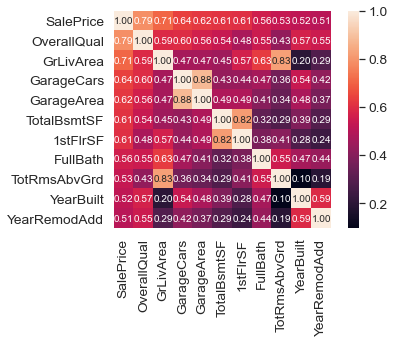

In [61]:
#saleprice correlation matrix
k = 11 #number of variables for heatmap
corrmat = df_train.corr()
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

The heatmap shows top 10 features that have highest correlation with SalePrice in order. Now it's better to think all of these features add unique information for the prediction individually.

1) 'GarageCars' and 'GarageArea' are redundant features. Even though the correlations with SalesPrice are very similar, let's take 'GarageCars' which is slightly higher.  
2) 'TotalBsmtSF' and '1stFlrSF' (First Floor square feet) also seem to be redundant. Let's keep 'TotalBsmtSF'.
3) 'FullBath' (Full bathrooms above grade)  
4) 'TotRmsAbvGrd' (Total rooms above grade) and 'GrLivArea' (Above grade (ground) living area square feet) are redundant. Let's keep GrLivArea.
5) 'YearBuilt'

Thus, we will exclude 'GarageArea', '1stFlrSF', 'TotRmsAbvGrd'

In [62]:
df_train = df_train.drop(['GarageArea', '1stFlrSF', 'TotRmsAbvGrd'],axis=1)

In [63]:
df_train.shape

(1460, 77)

Now we have 77 features.

# Feature Engineering

## SalePrice

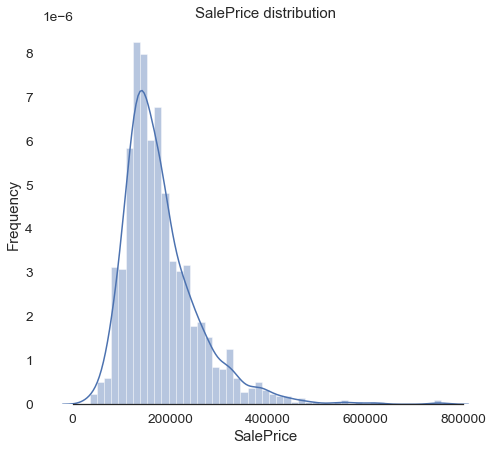

In [64]:
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
#Check the new distribution 
sns.distplot(df_train['SalePrice'], color="b");
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")
sns.despine(trim=True, left=True)
plt.show()

As we saw above, SalePrice feature is skewed to the right. Since most models can't deal with non-normality, I can apply a log(1+x) transfrom to make it normally distributed.

The logarithmic is a strong transformation that has a major effect on distribution shape. This technique is oftenly used for reducing right skewness.

In [65]:
# log(1+x) transform
df_train["SalePrice"] = np.log1p(df_train["SalePrice"])

Now let's see how the log transform works.


 mu = 12.02 and sigma = 0.40



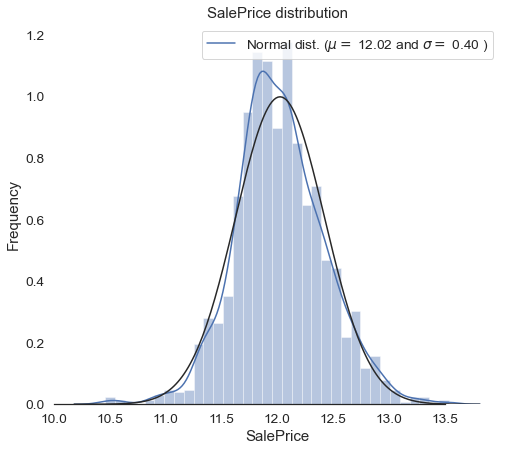

In [66]:
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
#Check the new distribution 
sns.distplot(df_train['SalePrice'] , fit=norm, color="b")

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df_train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")
sns.despine(trim=True, left=True)

plt.show()

Now SalePrice is normally distributed.

## Outliers

Let's check if there is an outliers in the features with high correlation with SalePrice. <br>
The first plot is scatter plots for top 5 features

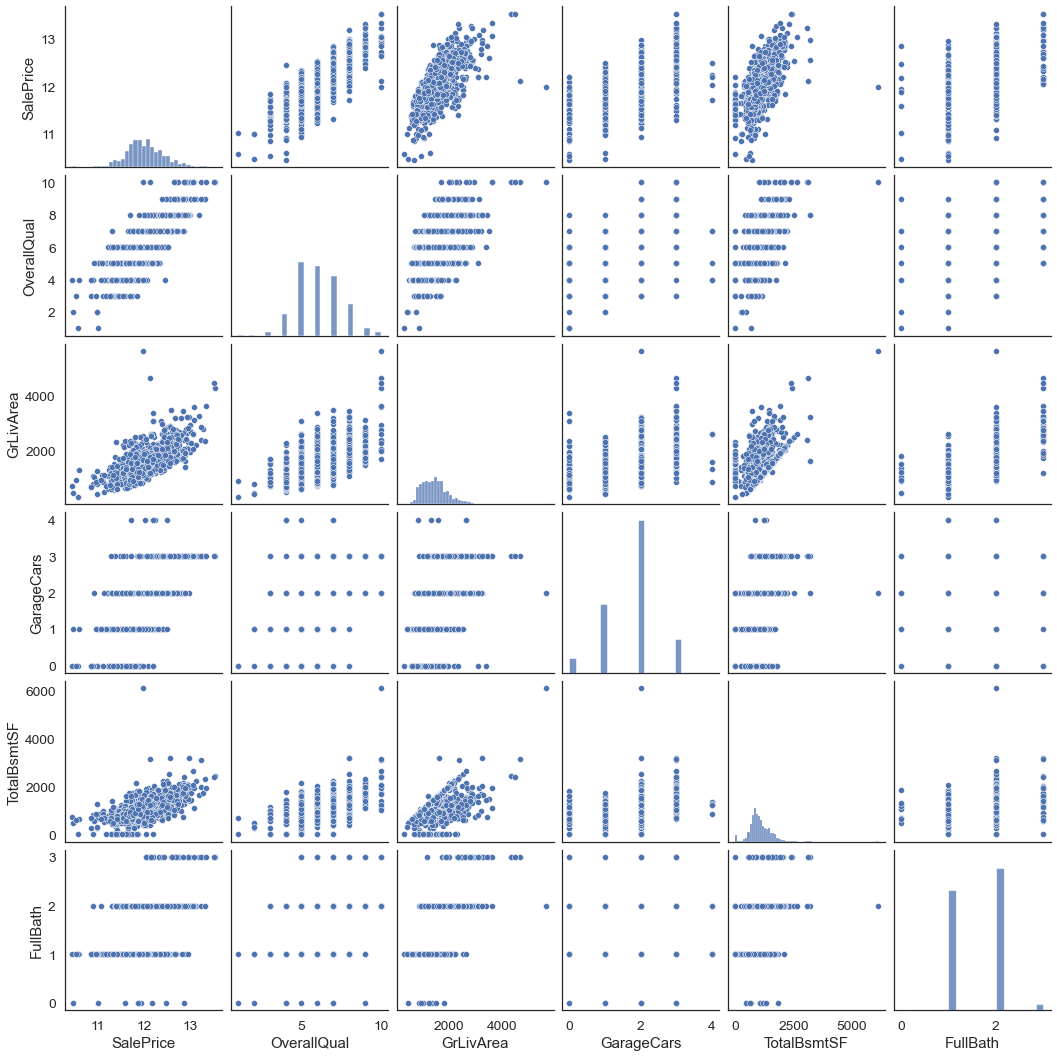

In [67]:
corrmat = df_train.corr()
cols = corrmat.nlargest(11, 'SalePrice')['SalePrice'].index
sns.pairplot(data=df_train[cols[0:6]])

Below is top 6 to 10 features.

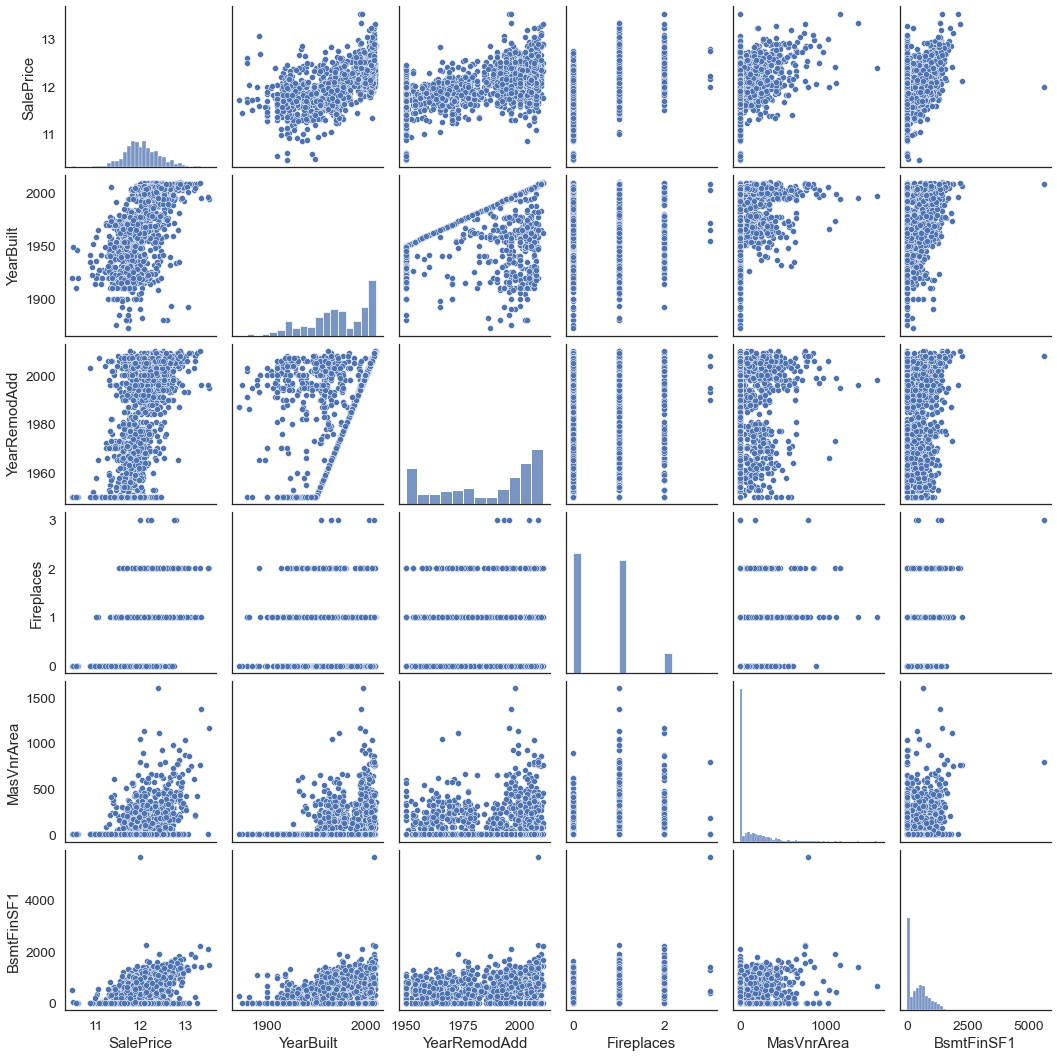

In [68]:
cols2 = cols[0:1].tolist()+cols[6:11].tolist()
sns.pairplot(data=df_train[cols2])

When we see the scatter plot between GrLivArea and SalePrice, we can easily notice that there are 2 outliers that are very different from the trend. 

<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

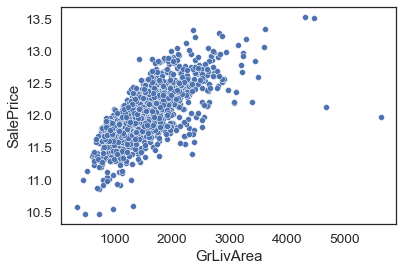

In [69]:
sns.scatterplot(data = df_train, x = 'GrLivArea', y = 'SalePrice')

As you can see, the two data points in the right are clearly outliers. Those two are very exceptional cases that might not help to predict houseprices for usual cases. Therefore, I will remove these two data points as below.

In [70]:
df_train.shape

(1460, 77)

We have 1460 datapoints before excluding outliers.

In [71]:
# Remove outliers
df_train = df_train.drop(df_train[(df_train['GrLivArea']>4500) & (df_train['SalePrice']<300000)].index)
df_train = df_train.reset_index(drop = True)

Removed outliers.

In [72]:
df_train.shape

(1458, 77)

Now we have 1458 data points.

## Missing data : Training data

We are going to deal with missing values for training and test data separately due to possibility of data leak from training data to test data. Let's do training data first.

In [73]:
# Missing data
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()*100).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1)
# add feature type info
missing_data = pd.concat([missing_data, df_train[missing_data.index].dtypes], axis = 1)
missing_data.columns = ['Total', 'Percent', 'Type']
missing_data[missing_data['Total']>0]

,Total,Percent,Type
PoolQC,1452,99.588477,object
MiscFeature,1404,96.296296,object
Alley,1367,93.758573,object
Fence,1177,80.727023,object
FireplaceQu,690,47.325103,object
LotFrontage,259,17.764060,float64
GarageCond,81,5.555556,object
GarageType,81,5.555556,object
GarageYrBlt,81,5.555556,object
GarageFinish,81,5.555556,object


There are some features with lots of missing values. I will deal with those features as below: <br><br>

1) For categorical features, I'll fill missing values with different stategies depending on each feature as below <br>
2) For numerical features, I'll impute missing values using Imputer by sklearn <br>

### Fill Missing values : Categorical features  

1. 'Electrical' : Fill missing values with most frequent value <br>
       
       Electrical: Electrical system

              SBrkr	Standard Circuit Breakers & Romex
              FuseA	Fuse Box over 60 AMP and all Romex wiring (Average)	
              FuseF	60 AMP Fuse Box and mostly Romex wiring (Fair)
              FuseP	60 AMP Fuse Box and mostly knob & tube wiring (poor)
              Mix	Mixed
2. 'PoolQC' : The data description stats that NA refers to "No Pool" <br>
       
       PoolQC: Pool quality
                     
              Ex	Excellent
              Gd	Good
              TA	Average/Typical
              Fa	Fair
              NA	No Pool
3. 'GarageYrBlt' : Replacing the missing values with 0, since no garage = no cars in garage <br>
       
       GarageYrBlt: Year garage was built
4. 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond' : Replacing the missing values with None

       GarageType: Garage location
                     
              2Types	More than one type of garage
              Attchd	Attached to home
              Basment	Basement Garage
              BuiltIn	Built-In (Garage part of house - typically has room above garage)
              CarPort	Car Port
              Detchd	Detached from home
              NA	No Garage <br>
       GarageQual: Garage quality

                     Ex	Excellent
                     Gd	Good
                     TA	Typical/Average
                     Fa	Fair
                     Po	Poor
                     NA	No Garage
       GarageCond: Garage condition

                     Ex	Excellent
                     Gd	Good
                     TA	Typical/Average
                     Fa	Fair
                     Po	Poor
                     NA	No Garage

5. 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'
: NaN values for these categorical basement features, means there's no basement<br>

       BsmtQual: Evaluates the height of the basement

              Ex	Excellent (100+ inches)	
              Gd	Good (90-99 inches)
              TA	Typical (80-89 inches)
              Fa	Fair (70-79 inches)
              Po	Poor (<70 inches
              NA	No Basement
       BsmtCond: Evaluates the general condition of the basement

              Ex	Excellent
              Gd	Good
              TA	Typical - slight dampness allowed
              Fa	Fair - dampness or some cracking or settling
              Po	Poor - Severe cracking, settling, or wetness
              NA	No Basement
       BsmtExposure: Refers to walkout or garden level walls

              Gd	Good Exposure
              Av	Average Exposure (split levels or foyers typically score average or above)	
              Mn	Mimimum Exposure
              No	No Exposure
              NA	No Basement
       BsmtFinType1: Rating of basement finished area

              GLQ	Good Living Quarters
              ALQ	Average Living Quarters
              BLQ	Below Average Living Quarters	
              Rec	Average Rec Room
              LwQ	Low Quality
              Unf	Unfinshed
              NA	No Basement
              
       BsmtFinType2: Rating of basement finished area (if multiple types)

              GLQ	Good Living Quarters
              ALQ	Average Living Quarters
              BLQ	Below Average Living Quarters	
              Rec	Average Rec Room
              LwQ	Low Quality
              Unf	Unfinshed
              NA	No Basement
6) For the rest of categorical features, we don't have any intuition about how to fill na. So we replace their missing values with None

In [74]:
# Fill missing values with most frequent value
df_train['Electrical'] = df_train['Electrical'].fillna("SBrkr")

# The data description stats that NA refers to "No Pool"
df_train["PoolQC"] = df_train["PoolQC"].fillna("None")

# Replacing the missing values with 0, since no garage = no cars in garage
df_train['GarageYrBlt'] = df_train['GarageYrBlt'].fillna(0)

# Replacing the missing values with None
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    df_train[col] = df_train[col].fillna('None')

# NaN values for these categorical basement features, means there's no basement
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    df_train[col] = df_train[col].fillna('None')

# For the rest of categorical features, we don't have any intuition about how to fill na
# So we replace their missing values with None

# Get categorical values with more than 1 missing value
objects = missing_data[(missing_data['Type'] == object) & (missing_data['Total'] > 0)].index
# Fill na with None
df_train.update(df_train[objects].fillna('None'))

Let's check how data looks like now.

In [75]:
# Missing data
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()*100).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1)
# add feature type info
missing_data = pd.concat([missing_data, df_train[missing_data.index].dtypes], axis = 1)
missing_data.columns = ['Total', 'Percent', 'Type']
missing_data[missing_data['Total']>0]

,Total,Percent,Type
LotFrontage,259,17.764060,float64
MasVnrArea,8,0.548697,float64


Now we only have two numerical features with missing values.

### Fill Missing values : Numerical features  

We will use mean value to impute missing values for numerical values.

In [76]:
# Get numerical values with more than 1 missing value ('LotFrontage', 'MasVnrArea')
num = missing_data[(missing_data['Type'] != object) & (missing_data['Total'] > 0)].index

# Load imputer
my_imputer = SimpleImputer(missing_values = np.NaN, strategy = 'mean')

# Fill missing value with mean 
for col in num:
    df_train[col] = my_imputer.fit_transform(df_train[col].values.reshape(-1, 1))[:, 0]

In [77]:
# Missing data
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()*100).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1)
# add feature type info
missing_data = pd.concat([missing_data, df_train[missing_data.index].dtypes], axis = 1)
missing_data.columns = ['Total', 'Percent', 'Type']
missing_data[missing_data['Total']>0]

,Total,Percent,Type


Now there is no missing value in the training data set.

Then, let's see missing values in test data set.

## Missing data : Test data

In [78]:
# Missing data
total = df_test.isnull().sum().sort_values(ascending=False)
percent = (df_test.isnull().sum()/df_test.isnull().count()*100).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1)
# add feature type info
missing_data = pd.concat([missing_data, df_test[missing_data.index].dtypes], axis = 1)
missing_data.columns = ['Total', 'Percent', 'Type']
missing_data[missing_data['Total']>0]

,Total,Percent,Type
PoolQC,1456,99.794380,object
MiscFeature,1408,96.504455,object
Alley,1352,92.666210,object
Fence,1169,80.123372,object
FireplaceQu,730,50.034270,object
LotFrontage,227,15.558602,float64
GarageCond,78,5.346127,object
GarageFinish,78,5.346127,object
GarageYrBlt,78,5.346127,object
GarageQual,78,5.346127,object


Let's do same thing we did for training data to test data 

### Fill Missing values : Categorical features  

In [79]:
# the data description states that NA refers to typical ('Typ') values
df_test['Functional'] = df_test['Functional'].fillna('Typ')

# Replace the missing values in each of the columns below with their mode
df_test['KitchenQual'] = df_test['KitchenQual'].fillna(df_test['KitchenQual'].mode()[0])
df_test['Exterior1st'] = df_test['Exterior1st'].fillna(df_test['Exterior1st'].mode()[0])
df_test['Exterior2nd'] = df_test['Exterior2nd'].fillna(df_test['Exterior2nd'].mode()[0])
df_test['SaleType'] = df_test['SaleType'].fillna(df_test['SaleType'].mode()[0])
df_test['MSZoning'] = df_test.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

# the data description stats that NA refers to "No Pool"
df_test["PoolQC"] = df_test["PoolQC"].fillna("None")

# Replacing the missing values with 0, since no garage = no cars in garage
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    df_test[col] = df_test[col].fillna(0)

# Replacing the missing values with None
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    df_test[col] = df_test[col].fillna('None')

# NaN values for these categorical basement features, means there's no basement
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    df_test[col] = df_test[col].fillna('None')

# For the rest of categorical features, we don't have any intuition about how to fill na
# So we replace their missing values with None

# Get categorical values with more than 1 missing value
objects = missing_data[(missing_data['Type'] == object) & (missing_data['Total'] > 0)].index
# Fill na with None
df_test.update(df_test[objects].fillna('None'))

In [80]:
# Missing data
total = df_test.isnull().sum().sort_values(ascending=False)
percent = (df_test.isnull().sum()/df_test.isnull().count()*100).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1)
# add feature type info
missing_data = pd.concat([missing_data, df_test[missing_data.index].dtypes], axis = 1)
missing_data.columns = ['Total', 'Percent', 'Type']
missing_data[missing_data['Total']>0]

,Total,Percent,Type
LotFrontage,227,15.558602,float64
MasVnrArea,15,1.028101,float64
BsmtHalfBath,2,0.137080,float64
BsmtFullBath,2,0.137080,float64
BsmtFinSF1,1,0.068540,float64
BsmtUnfSF,1,0.068540,float64
BsmtFinSF2,1,0.068540,float64
TotalBsmtSF,1,0.068540,float64


Now all the missing values in categorical features are filled. Let's impute missing values in numerical features.

### Fill Missing values : Numerical features  

In [81]:
# Get numerical values with more than 1 missing value ('LotFrontage', 'MasVnrArea')
num = missing_data[(missing_data['Type'] != object) & (missing_data['Total'] > 0)].index

# Load imputer
my_imputer = SimpleImputer(missing_values = np.NaN, strategy = 'mean')

# Fill missing value with mean 
for col in num:
    df_test[col] = my_imputer.fit_transform(df_test[col].values.reshape(-1, 1))[:, 0]

In [82]:
# Missing data
total = df_test.isnull().sum().sort_values(ascending=False)
percent = (df_test.isnull().sum()/df_test.isnull().count()*100).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1)
# add feature type info
missing_data = pd.concat([missing_data, df_test[missing_data.index].dtypes], axis = 1)
missing_data.columns = ['Total', 'Percent', 'Type']
missing_data[missing_data['Total']>0]

,Total,Percent,Type


Now we don't have any missing values for test data

## Match the dimension between train and test data

There are some features dropped from training data earlier. Those also should be excluded from test data to match the dimension between training and test for modeling procedure later. 

In [83]:
# Split features and labels in training data
train_y = df_train['SalePrice'].reset_index(drop=True)
df_train = df_train.drop(['SalePrice'], axis=1)

# Exclude features that are dropped from training data
commonlabel=[x for x in df_train.columns if x in df_test.columns]
df_test = df_test[commonlabel]

In [84]:
print(df_train.shape, df_test.shape)

(1458, 76) (1459, 76)


Now we have same number of feature for training and test data.

## Fix Skewness in numeric features : Training data

Let's find the numeric features which are not normally distributed and fix those.

In [85]:
# Extract name of numeric features
numeric=df_train.dtypes[df_train.dtypes!='object'].index.tolist()

We can see the distribution of numeric features using box plot.

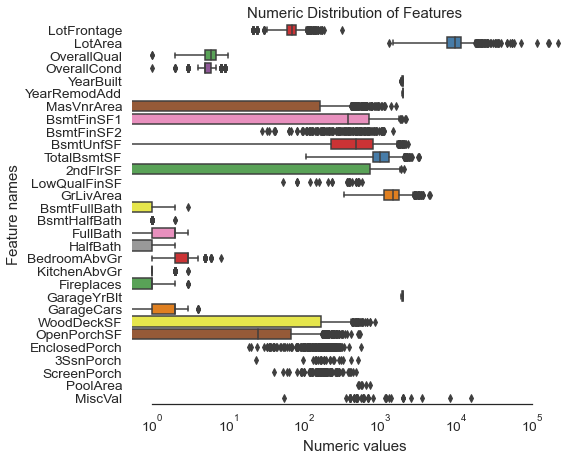

In [86]:
# Create box plots for all numeric features
sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log")
ax = sns.boxplot(data=df_train[numeric] , orient="h", palette="Set1")
ax.xaxis.grid(False)
ax.set(ylabel="Feature names")
ax.set(xlabel="Numeric values")
ax.set(title="Numeric Distribution of Features")
sns.despine(trim=True, left=True)

We can see some features are highly skewed. Let's calculate skewness for each numerical feature and see the features highly skewed. When skewness is higher than 0.5, it is considered highly skewed.

In [91]:
# Find skewed numerical features
skew_features = df_train[numeric].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5] # When skewness is higher than 0.5, it is considered non-normality
skew_index = high_skew.index

print("There are {} numerical features with Skew > 0.5 :".format(high_skew.shape[0]))
skewness = pd.DataFrame({'Skew' :high_skew})
skew_features[skew_features>0.5]

There are 16 numerical features with Skew > 0.5 :


PoolArea         15.624014
3SsnPorch         7.738673
LowQualFinSF      7.387253
MiscVal           5.196004
KitchenAbvGr      3.950205
BsmtHalfBath      3.921995
ScreenPorch       3.325527
BsmtFinSF2        2.642694
EnclosedPorch     2.283671
MasVnrArea        0.941294
2ndFlrSF          0.884856
WoodDeckSF        0.778333
HalfBath          0.715231
OpenPorchSF       0.624950
BsmtFullBath      0.585429
Fireplaces        0.510757
dtype: float64

These 23 features are considered highly skewed in training data.

Applying Box-Cox transformation will allow us to normalize those 18 features.

The Box-Cox transformation is, as you probably understand, also a technique to transform non-normal data into normal shape. This is a procedure to identify a suitable exponent (Lambda = l) to use to transform skewed data.

Let's use Box-Cox transformation to fix the skewness.

In [88]:
# Normalize skewed features
for i in skew_index:
    df_train[i] = boxcox1p(df_train[i], boxcox_normmax(df_train[i] + 1))

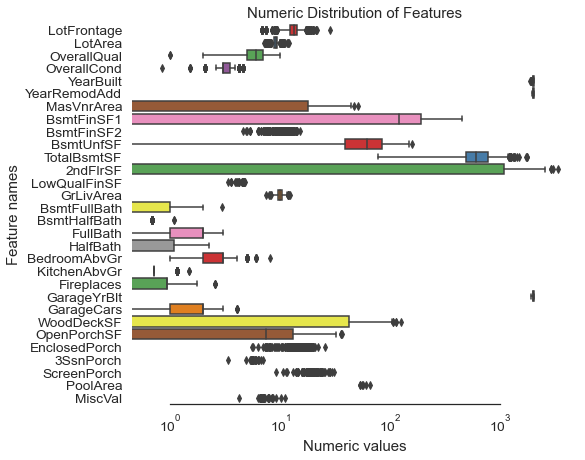

In [41]:
# Create box plots for all numeric features
sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log")
ax = sns.boxplot(data=df_train[numeric] , orient="h", palette="Set1")
ax.xaxis.grid(False)
ax.set(ylabel="Feature names")
ax.set(xlabel="Numeric values")
ax.set(title="Numeric Distribution of Features")
sns.despine(trim=True, left=True)

## Fix Skewness in numeric features : Test data

Let's do same thing for test data

In [42]:
# Extract name of numeric features
numeric=df_test.dtypes[df_test.dtypes!='object'].index.tolist()

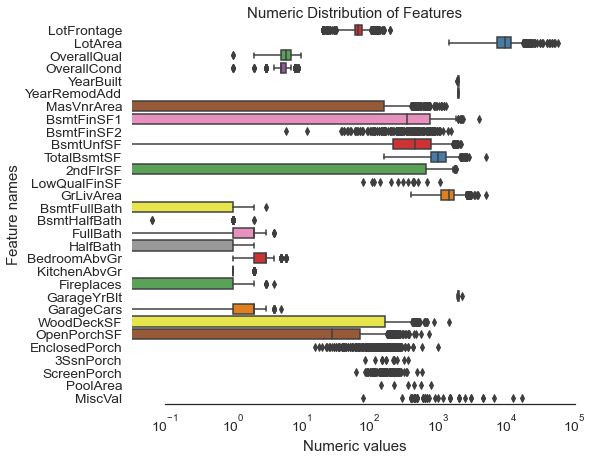

In [43]:
# Create box plots for all numeric features
sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log")
ax = sns.boxplot(data=df_test[numeric] , orient="h", palette="Set1")
ax.xaxis.grid(False)
ax.set(ylabel="Feature names")
ax.set(xlabel="Numeric values")
ax.set(title="Numeric Distribution of Features")
sns.despine(trim=True, left=True)

In [90]:
# Find skewed numerical features
skew_features = df_test[numeric].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5] # When skewness is higher than 0.5, it is considered non-normality
skew_index = high_skew.index

print("There are {} numerical features with Skew > 0.5 :".format(high_skew.shape[0]))
skewness = pd.DataFrame({'Skew' :high_skew})
skew_features.head(10)

There are 22 numerical features with Skew > 0.5 :


PoolArea         20.176117
MiscVal          20.054543
LowQualFinSF     16.150628
3SsnPorch        12.511336
EnclosedPorch     4.664371
KitchenAbvGr      4.074860
BsmtFinSF2        4.038570
ScreenPorch       3.784349
BsmtHalfBath      3.778564
LotArea           3.112013
dtype: float64

Let's apply Box-Cox transformation.

In [45]:
# Normalize skewed features
for i in skew_index:
    df_test[i] = boxcox1p(df_test[i], boxcox_normmax(df_test[i] + 1))

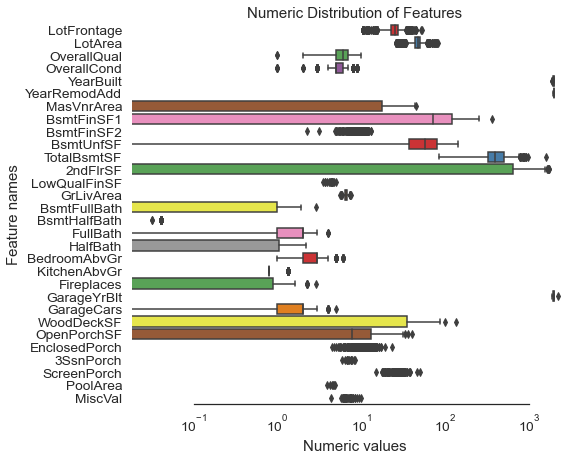

In [46]:
# Create box plots for all numeric features
sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log")
ax = sns.boxplot(data=df_test[numeric] , orient="h", palette="Set1")
ax.xaxis.grid(False)
ax.set(ylabel="Feature names")
ax.set(xlabel="Numeric values")
ax.set(title="Numeric Distribution of Features")
sns.despine(trim=True, left=True)

## Encode categotical variables

Using one hot encoding, we can encode categorical features that can be fed into machine learning models.
We should concatenate train and test data here to get same number of dimension for each since some categorical values are different in number for train and test data.

In [48]:
# Combine df_train and test features in order to apply the feature transformation pipeline to the entire dataset
df_all = pd.concat([df_train, df_test]).reset_index(drop=True)

# one hot encoding for categorical features
df_all = pd.get_dummies(df_all).reset_index(drop=True)
df_all.shape

(2917, 329)

We merged training and test data, and created dummy variables for categorical features. Now the dataframe has 329 features with 2917 datapoints.

## Save data
Let's split data into train and test data again and save the data for the following modeling process in a separate notebook.

In [50]:
# Split concatenated data
train_X = df_all.iloc[:len(train_y), :]
test_X = df_all.iloc[len(train_y):, :]
train_X.shape, train_y.shape, test_X.shape

((1458, 329), (1458,), (1459, 329))

In [51]:
# Save processed data
train_X.to_csv('../data/processed/train_X.csv',index=False)
train_y.to_csv('../data/processed/train_y.csv',index=False)
test_X.to_csv('../data/processed/test_X.csv',index=False)